In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!git clone https://github.com/AlexGraikos/food_volume_estimation.git

In [ ]:
cd food_volume_estimation

In [ ]:
!pip install -r requirements.txt
!pip install h5py==2.9.0 --force-reinstall
!pip install numpy==1.16.3 --force-reinstall
!pip install matplotlib==3.0.3 --force-reinstall

In [ ]:
!python setup.py install

In [ ]:
import sys
import json
from keras.models import Model, model_from_json
from food_volume_estimation.depth_estimation.custom_modules import *
from food_volume_estimation.food_segmentation.food_segmentator import FoodSegmentator
import matplotlib.pyplot as plt
from pyntcloud import PyntCloud

# Paths to model archiecture/weights
depth_model_architecture = '/content/gdrive/MyDrive/monovideo_fine_tune_food_videos.json'
depth_model_weights = '/content/gdrive/MyDrive/monovideo_fine_tune_food_videos.h5'
segmentation_model_weights = '/content/gdrive/MyDrive/mask_rcnn_food_segmentation.h5'

In [ ]:
import os
import argparse
import numpy as np
import pandas as pd
import cv2
import json
from scipy.spatial.distance import pdist
from scipy.stats import skew
from keras.models import Model, model_from_json
import keras.backend as K
from fuzzywuzzy import fuzz, process 
import matplotlib.pyplot as plt
from food_volume_estimation.depth_estimation.custom_modules import *
from food_volume_estimation.depth_estimation.project import *
from food_volume_estimation.food_segmentation.food_segmentator import FoodSegmentator
from food_volume_estimation.ellipse_detection.ellipse_detector import EllipseDetector
from food_volume_estimation.point_cloud_utils import *

In [ ]:
class DensityDatabase():
    def __init__(self, db_path):
        if os.path.exists(db_path):
            # Read density database from excel file
            self.density_database = pd.read_excel(
                db_path, sheet_name=0, usecols=[0, 1])
        else:
            # Read density database from Google Sheets URL
            sheet = 'Sheet1'
            url = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(db_path, sheet)
            self.density_database = pd.read_csv(url, usecols=[0, 1], header=None)
        # Remove rows with NaN values
        self.density_database.dropna(inplace=True)

    def query(self, food):
        try:
            # Search for matching food in database
            match = process.extractOne(food, self.density_database.values[:,0],
                                       scorer=fuzz.partial_ratio,
                                       score_cutoff=80)
            db_entry = (
                self.density_database.loc[
                self.density_database[
                self.density_database.columns[0]] == match[0]])
            db_entry_vals = db_entry.values
            return db_entry_vals[0]
        except:
            return ['None', 1]

In [ ]:
volume = []

class VolumeEstimator():
    def __init__(self, arg_init=True):

        if not arg_init:
            print('[*] VolumeEstimator not initialized.')
        else:    
            self.args = self.__parse_args()

            # Load depth estimation model
            custom_losses = Losses()
            objs = {'ProjectionLayer': ProjectionLayer,'ReflectionPadding2D': ReflectionPadding2D,
                    'InverseDepthNormalization': InverseDepthNormalization,'AugmentationLayer': AugmentationLayer,
                    'compute_source_loss': custom_losses.compute_source_loss}
            with open(self.args.depth_model_architecture, 'r') as read_file:
                model_architecture_json = json.load(read_file)
                self.monovideo = model_from_json(model_architecture_json, custom_objects=objs)
            self.__set_weights_trainable(self.monovideo, False)
            self.monovideo.load_weights(self.args.depth_model_weights)
            self.model_input_shape = (self.monovideo.inputs[0].shape.as_list()[1:])
            depth_net = self.monovideo.get_layer('depth_net')
            self.depth_model = Model(inputs=depth_net.inputs, outputs=depth_net.outputs, name='depth_model')
            print('[*] Loaded depth estimation model.')
            # Depth model configuration
            self.min_disp = 1 / self.args.max_depth
            self.max_disp = 1 / self.args.min_depth
            self.gt_depth_scale = self.args.gt_depth_scale
            self.segmentator = FoodSegmentator(self.args.segmentation_weights)
            self.relax_param = self.args.relaxation_param

            if self.args.density_db is not None:
                self.density_db = DensityDatabase(self.args.density_db)

    def __parse_args(self):
        """Parse command-line input arguments.
        Returns:
            args: The arguments object.
        """
        # Parse command line arguments
        parser = argparse.ArgumentParser(
            description='Estimate food volume in input images.')
        parser.add_argument('--input_images', type=str, nargs='+', help='Paths to input images.', metavar='/path/to/image1 /path/to/image2 ...', required=True)
        parser.add_argument('--depth_model_architecture', type=str,help=('Depth estimation model ''architecture (.json).'),metavar='/path/to/architecture.json', required=True)
        parser.add_argument('--depth_model_weights', type=str, help='Depth estimation model weights (.h5).', metavar='/path/to/weights.h5', required=True)
        parser.add_argument('--segmentation_weights', type=str, help='Food segmentation model weights (.h5).', metavar='/path/to/weights.h5', required=True)
        parser.add_argument('--fov', type=float, help='Camera Field of View (in deg).', metavar='<fov>', default=70)
        parser.add_argument('--plate_diameter_prior', type=float, help=('Expected plate diameter (in m) ' + 'or 0 to ignore plate scaling'), metavar='<plate_diameter_prior>', default=0.0)
        parser.add_argument('--gt_depth_scale', type=float,help='Ground truth depth rescaling factor.',metavar='<gt_depth_scale>',default=0.35)
        parser.add_argument('--min_depth', type=float,help='Minimum depth value.',metavar='<min_depth>',default=0.01)
        parser.add_argument('--max_depth', type=float,help='Maximum depth value.',metavar='<max_depth>',default=10)
        parser.add_argument('--relaxation_param', type=float,help='Plate adjustment relaxation parameter.',metavar='<relaxation_param>', default=0.01)
        parser.add_argument('--plot_results', action='store_true', help='Plot volume estimation results.', default=False)
        parser.add_argument('--results_file', type=str,help='File to save results at (.csv).',metavar='/path/to/results.csv',default=None)
        parser.add_argument('--plots_directory', type=str,help='Directory to save plots at (.png).',metavar='/path/to/plot/directory/',default=None)
        parser.add_argument('--density_db', type=str, help=('Path to food density database (.xlsx) ' + 'or Google Sheets ID.'),metavar='/path/to/plot/database.xlsx or <ID>', default=None)
        parser.add_argument('--food_type', type=str,  help='Food type to calculate weight for.', metavar='<food_type>', default=None)
        args = parser.parse_args()
        
        return args

    def estimate_volume(self, input_image, fov=70,  plate_diameter_prior=0.3,
            plot_results=False, plots_directory=None):
        """Volume estimation procedure.
        Inputs:
            input_image: Path to input image or image array.
            fov: Camera Field of View.
            plate_diameter_prior: Expected plate diameter.
            plot_results: Result plotting flag.
            plots_directory: Directory to save plots at or None.
        Returns:
            estimated_volume: Estimated volume.
        """
        # Load input image and resize to model input size
        if isinstance(input_image, str):
            img = cv2.imread(input_image, cv2.IMREAD_COLOR)
        else:
            img = input_image
        input_image_shape = img.shape
        img = cv2.resize(img, (self.model_input_shape[1],
                               self.model_input_shape[0]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255

        # Create intrinsics matrix
        intrinsics_mat = self.__create_intrinsics_matrix(input_image_shape,fov)
        intrinsics_inv = np.linalg.inv(intrinsics_mat)

        # Predict depth
        img_batch = np.reshape(img, (1,) + img.shape)
        inverse_depth = self.depth_model.predict(img_batch)[0][0,:,:,0] 
        disparity_map = (self.min_disp + (self.max_disp - self.min_disp) * inverse_depth)
        depth = 1 / disparity_map
        # Convert depth map to point cloud
        depth_tensor = K.variable(np.expand_dims(depth, 0))
        intrinsics_inv_tensor = K.variable(np.expand_dims(intrinsics_inv, 0))
        point_cloud = K.eval(get_cloud(depth_tensor, intrinsics_inv_tensor))
        point_cloud_flat = np.reshape(point_cloud, (point_cloud.shape[1] * point_cloud.shape[2], 3))

        # Find ellipse parameterss (cx, cy, a, b, theta) that 
        # describe the plate contour
        ellipse_scale = 2
        ellipse_detector = EllipseDetector(
            (ellipse_scale * self.model_input_shape[0],
             ellipse_scale * self.model_input_shape[1]))
        ellipse_params = ellipse_detector.detect(input_image)
        ellipse_params_scaled = tuple(
            [x / ellipse_scale for x in ellipse_params[:-1]]
            + [ellipse_params[-1]])

        # Scale depth map
        if (any(x != 0 for x in ellipse_params_scaled) and
                plate_diameter_prior != 0):
            print('[*] Ellipse parameters:', ellipse_params_scaled)
            # Find the scaling factor to match prior 
            # and measured plate diameters
            plate_point_1 = [int(ellipse_params_scaled[2] 
                             * np.sin(ellipse_params_scaled[4]) 
                             + ellipse_params_scaled[1]), 
                             int(ellipse_params_scaled[2] 
                             * np.cos(ellipse_params_scaled[4]) 
                             + ellipse_params_scaled[0])]
            plate_point_2 = [int(-ellipse_params_scaled[2] 
                             * np.sin(ellipse_params_scaled[4]) 
                             + ellipse_params_scaled[1]),
                             int(-ellipse_params_scaled[2] 
                             * np.cos(ellipse_params_scaled[4]) 
                             + ellipse_params_scaled[0])]
            plate_point_1_3d = point_cloud[0, plate_point_1[0], 
                                           plate_point_1[1], :]
            plate_point_2_3d = point_cloud[0, plate_point_2[0], 
                                           plate_point_2[1], :]
            plate_diameter = np.linalg.norm(plate_point_1_3d 
                                            - plate_point_2_3d)
            scaling = plate_diameter_prior / plate_diameter
        else:
            # Use the median ground truth depth scaling when not using
            # the plate contour
            print('[*] No ellipse found. Scaling with expected median depth.')
            predicted_median_depth = np.median(1 / disparity_map)
            scaling = self.gt_depth_scale / predicted_median_depth
        depth = scaling * depth
        point_cloud = scaling * point_cloud
        point_cloud_flat = scaling * point_cloud_flat

        # Predict segmentation masks
        masks_array = self.segmentator.infer_masks(input_image)
        print('[*] Found {} food object(s) '
              'in image.'.format(masks_array.shape[-1]))

        # Iterate over all predicted masks and estimate volumes
        estimated_volumes = []
        for k in range(masks_array.shape[-1]):
            # Apply mask to create object image and depth map
            object_mask = cv2.resize(masks_array[:,:,k], 
                                     (self.model_input_shape[1],
                                      self.model_input_shape[0]))
            object_img = (np.tile(np.expand_dims(object_mask, axis=-1),
                                     (1,1,3)) * img)
            object_depth = object_mask * depth
            # Get object/non-object points by filtering zero/non-zero 
            # depth pixels
            object_mask = (np.reshape(
                object_depth, (object_depth.shape[0] * object_depth.shape[1]))
                > 0)
            object_points = point_cloud_flat[object_mask, :]
            non_object_points = point_cloud_flat[
                np.logical_not(object_mask), :]

            # Filter outlier points
            object_points_filtered, sor_mask = sor_filter(
                object_points, 2, 0.7)
            # Estimate base plane parameters
            plane_params = pca_plane_estimation(object_points_filtered)
            # Transform object to match z-axis with plane normal
            translation, rotation_matrix = align_plane_with_axis(
                plane_params, np.array([0, 0, 1]))
            object_points_transformed = np.dot(
                object_points_filtered + translation, rotation_matrix.T)

            # Adjust object on base plane
            height_sorted_indices = np.argsort(object_points_transformed[:,2])
            adjustment_index = height_sorted_indices[
                int(object_points_transformed.shape[0] * self.relax_param)]
            object_points_transformed[:,2] += np.abs(
                object_points_transformed[adjustment_index, 2])
             
            if (plot_results or plots_directory is not None):
                # Create object points from estimated plane
                plane_z = np.apply_along_axis(
                    lambda x: ((plane_params[0] + plane_params[1] * x[0]
                    + plane_params[2] * x[1]) * (-1) / plane_params[3]),
                    axis=1, arr=point_cloud_flat[:,:2])
                plane_points = np.concatenate(
                    (point_cloud_flat[:,:2], 
                    np.expand_dims(plane_z, axis=-1)), axis=-1)
                plane_points_transformed = np.dot(plane_points + translation, 
                                                  rotation_matrix.T)
                print('[*] Estimated plane parameters (w0,w1,w2,w3):',
                      plane_params)

                # Get the color values for the different sets of points
                colors_flat = (
                    np.reshape(img, (self.model_input_shape[0] 
                                     * self.model_input_shape[1], 3))
                    * 255)
                object_colors = colors_flat[object_mask, :]
                non_object_colors= colors_flat[np.logical_not(object_mask), :]
                object_colors_filtered = object_colors[sor_mask, :]

                # Create dataFrames for the different sets of points
                non_object_points_df = pd.DataFrame(
                    np.concatenate((non_object_points, non_object_colors), 
                                   axis=-1),
                    columns=['x','y','z','red','green','blue'])
                object_points_df = pd.DataFrame(
                    np.concatenate((object_points, object_colors), 
                    axis=-1), columns=['x','y','z','red','green','blue'])
                plane_points_df = pd.DataFrame(
                    plane_points, columns=['x','y','z'])
                object_points_transformed_df = pd.DataFrame(
                    np.concatenate((object_points_transformed, 
                                    object_colors_filtered), axis=-1),
                    columns=['x','y','z','red','green','blue'])
                plane_points_transformed_df = pd.DataFrame(
                    plane_points_transformed, columns=['x','y','z'])

                # Outline the detected plate ellipse and major axis vertices 
                plate_contour = np.copy(img)
                if (any(x != 0 for x in ellipse_params_scaled) and
                    plate_diameter_prior != 0):
                    ellipse_color = (68 / 255, 1 / 255, 84 / 255)
                    vertex_color = (253 / 255, 231 / 255, 37 / 255)
                    cv2.ellipse(plate_contour,
                                (int(ellipse_params_scaled[0]),
                                 int(ellipse_params_scaled[1])), 
                                (int(ellipse_params_scaled[2]),
                                 int(ellipse_params_scaled[3])),
                                ellipse_params_scaled[4] * 180 / np.pi, 
                                0, 360, ellipse_color, 2)
                    cv2.circle(plate_contour,
                               (int(plate_point_1[1]), int(plate_point_1[0])),
                               2, vertex_color, -1)
                    cv2.circle(plate_contour,
                               (int(plate_point_2[1]), int(plate_point_2[0])),
                               2, vertex_color, -1)

                # Estimate volume for points above the plane
                volume_points = object_points_transformed[
                    object_points_transformed[:,2] > 0]
                estimated_volume, simplices = pc_to_volume(volume_points)
                print('[*] Estimated volume:', estimated_volume * 1000, 'L')
                ################
                volume.append(round(estimated_volume * 1000, 3))
                # Create figure of input image and predicted 
                # plate contour, segmentation mask and depth map
                pretty_plotting([img, plate_contour, depth, object_img], 
                                (2,2),
                                ['Input Image', 'Plate Contour', 'Depth', 
                                 'Object Mask'],
                                'Estimated Volume: {:.3f} L'.format(
                                estimated_volume * 1000.0))

                # Plot and save figure
                if plot_results:
                    plt.show()
                if plots_directory is not None:
                    if not os.path.exists(plots_directory):
                        os.makedirs(plots_directory)
                    (img_name, ext) = os.path.splitext(
                        os.path.basename(input_image))
                    filename = '{}_{}{}'.format(img_name, plt.gcf().number,
                                                ext)
                    plt.savefig(os.path.join(plots_directory, filename))

                estimated_volumes.append(
                    (estimated_volume, object_points_df, non_object_points_df,
                     plane_points_df, object_points_transformed_df,
                     plane_points_transformed_df, simplices))
            else:
                # Estimate volume for points above the plane
                volume_points = object_points_transformed[
                    object_points_transformed[:,2] > 0]
                estimated_volume, _ = pc_to_volume(volume_points)
                estimated_volumes.append(estimated_volume)

        return estimated_volumes

    def __create_intrinsics_matrix(self, input_image_shape, fov):
        """Create intrinsics matrix from given camera fov.
        Inputs:
            input_image_shape: Original input image shape.
            fov: Camera Field of View (in deg).
        Returns:
            intrinsics_mat: Intrinsics matrix [3x3].
        """
        F = input_image_shape[1] / (2 * np.tan((fov / 2) * np.pi / 180))
        print('[*] Creating intrinsics matrix from given FOV:', fov)

        # Create intrinsics matrix
        x_scaling = int(self.model_input_shape[1]) / input_image_shape[1] 
        y_scaling = int(self.model_input_shape[0]) / input_image_shape[0] 
        intrinsics_mat = np.array(
            [[F * x_scaling, 0, (input_image_shape[1] / 2) * x_scaling], 
             [0, F * y_scaling, (input_image_shape[0] / 2) * y_scaling],
             [0, 0, 1]])
        return intrinsics_mat

    def __set_weights_trainable(self, model, trainable):
        """Sets model weights to trainable/non-trainable.
        Inputs:
            model: Model to set weights.
            trainable: Trainability flag.
        """
        for layer in model.layers:
            layer.trainable = trainable
            if isinstance(layer, Model):
                self.__set_weights_trainable(layer, trainable)

In [ ]:
estimator = VolumeEstimator(arg_init=False)
with open(depth_model_architecture, 'r') as read_file:
    custom_losses = Losses()
    objs = {'ProjectionLayer': ProjectionLayer,
            'ReflectionPadding2D': ReflectionPadding2D,
            'InverseDepthNormalization': InverseDepthNormalization,
            'AugmentationLayer': AugmentationLayer,
            'compute_source_loss': custom_losses.compute_source_loss}
    model_architecture_json = json.load(read_file)
    estimator.monovideo = model_from_json(model_architecture_json, custom_objects=objs)
estimator._VolumeEstimator__set_weights_trainable(estimator.monovideo, False)
estimator.monovideo.load_weights(depth_model_weights)
estimator.model_input_shape = estimator.monovideo.inputs[0].shape.as_list()[1:]
depth_net = estimator.monovideo.get_layer('depth_net')
estimator.depth_model = Model(inputs=depth_net.inputs, outputs=depth_net.outputs, name='depth_model')
print('[*] Loaded depth estimation model.')

# Depth model configuration
MIN_DEPTH = 0.01
MAX_DEPTH = 10
estimator.min_disp = 1 / MAX_DEPTH
estimator.max_disp = 1 / MIN_DEPTH
estimator.gt_depth_scale = 0.35 # Ground truth expected median depth

# Create segmentator object
estimator.segmentator = FoodSegmentator(segmentation_model_weights)

# Set plate adjustment relaxation parameter
estimator.relax_param = 0.01

[*] VolumeEstimator not initialized.
[*] Loaded depth estimation model.
[*] Loading segmentation model weights /content/gdrive/MyDrive/mask_rcnn_food_segmentation.h5


In [ ]:
import os

data_dir = '/content/gdrive/MyDrive/DCD_2022/음식 이미지 및 영양정보 텍스트/train_sampling/떡갈비/'

classes = []

for folder in os.listdir(data_dir):  
    temp = folder
    if "top" == temp.split('_')[0]:  
      classes.append(folder)

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.28938660703798263, 0.14313504842992947, -0.25681217394752176, -0.9558032565456709]
[*] Estimated volume: 0.1898177790466348 L


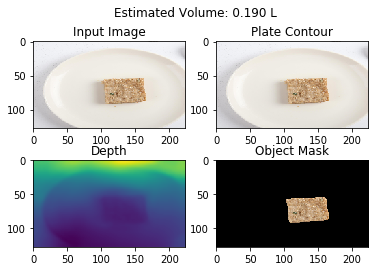

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.29732850560979374, 0.007161704499761075, -0.32375560982244594, -0.9461136375177954]
[*] Estimated volume: 0.28350591817276155 L


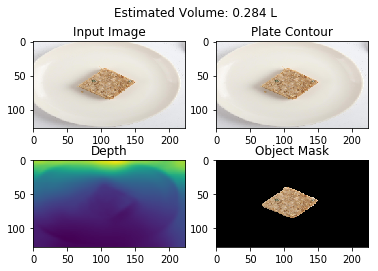

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.31883990258937317, 0.0654983110139012, -0.26071425076062876, -0.963191596051715]
[*] Estimated volume: 0.18981230183543807 L


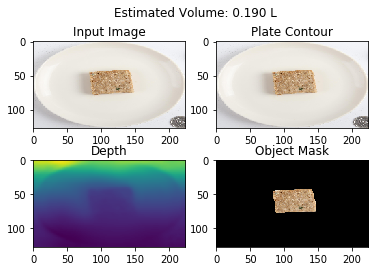

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.2886381213710083, 0.20755244026956546, -0.32075077085508935, -0.9241433479358138]
[*] Estimated volume: 0.14839379981582046 L


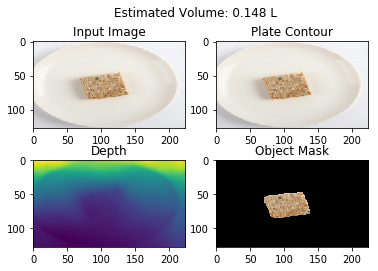

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.3016675108950388, 0.09803521648770007, -0.30881992675203435, -0.9460546227195753]
[*] Estimated volume: 0.3137612515605921 L


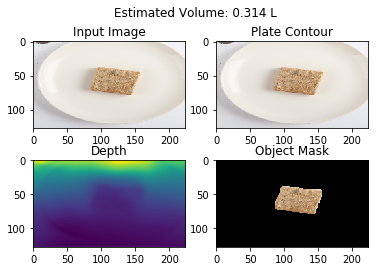

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.2952622451842447, 0.021518654446181375, -0.34480329416740957, -0.9384282795409187]
[*] Estimated volume: 0.27573596282766527 L


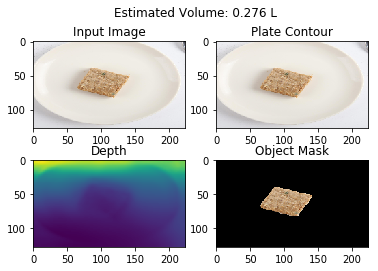

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.3021108677396242, 0.041701667902355875, -0.33360414794563786, -0.9417904455703651]
[*] Estimated volume: 0.30451067088082867 L


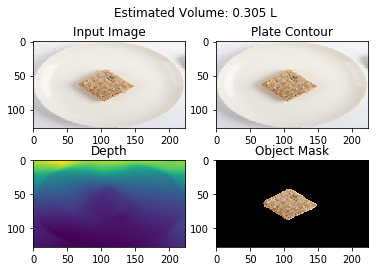

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.30524505003254854, 0.11177647921777942, -0.2952407776055331, -0.9488618982404959]
[*] Estimated volume: 0.27786552227524935 L


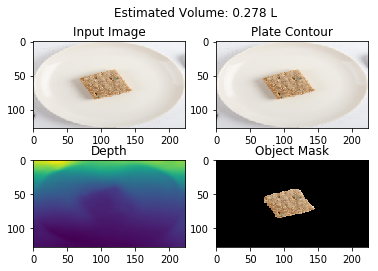

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.3091207058270712, 0.10260031619325145, -0.2343839214754101, -0.9667147213479547]
[*] Estimated volume: 0.22006197573499853 L


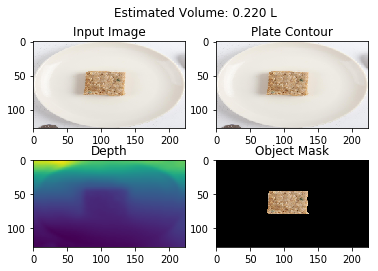

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.31286538418323573, 0.006699900747088774, -0.30322327744659955, -0.9528959834864041]
[*] Estimated volume: 0.35064344610593834 L


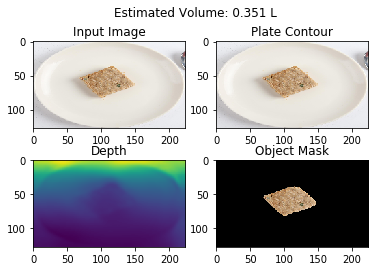

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.32639789981842543, 0.11481550435157951, -0.30416287415265375, -0.9456756029144928]
[*] Estimated volume: 0.30134461078513686 L


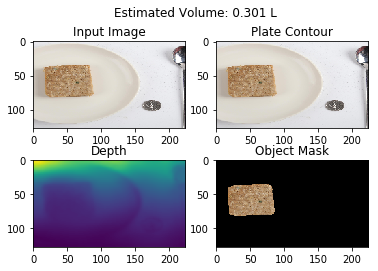

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.3227244885437498, 0.07399805504170806, -0.22489253686881217, -0.9715696756850506]
[*] Estimated volume: 0.7121599146402092 L


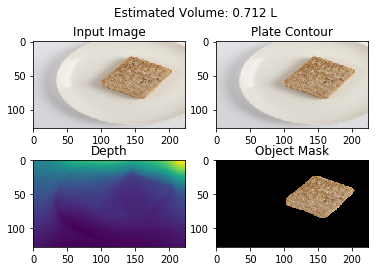

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.3158628789460046, 0.0637125701291116, -0.29358121408397597, -0.9538085652501354]
[*] Estimated volume: 0.8094751513832248 L


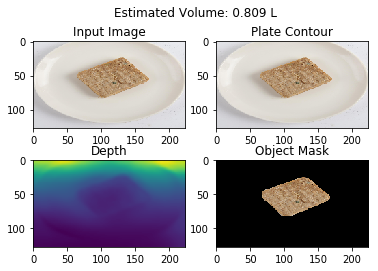

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.3083557547011411, 0.14885457660357992, -0.2917420637201108, -0.9448433114969379]
[*] Estimated volume: 0.6127592682506772 L


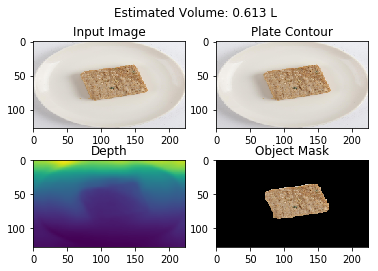

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.3028135144172431, 0.04068611884494327, -0.26169439361029073, -0.9642928414575509]
[*] Estimated volume: 0.47447086192357296 L


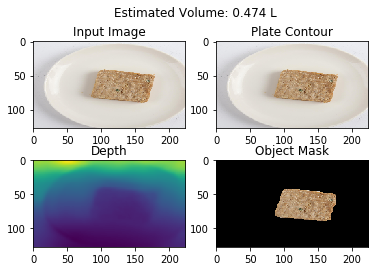

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.29955091216030755, -0.01111424394027536, -0.30050189558515694, -0.9537164590859085]
[*] Estimated volume: 0.7145152268164783 L


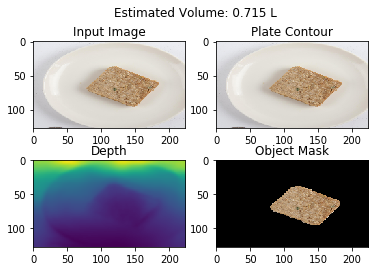

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.2919876221515637, 0.07533436507493645, -0.29232315978401135, -0.953347734928157]
[*] Estimated volume: 0.6534126508674102 L


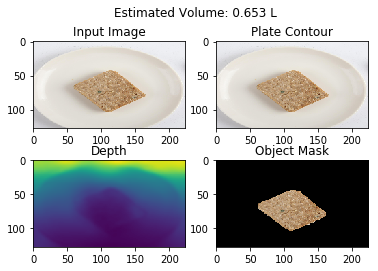

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.2959020098684408, 0.07931659312901321, -0.31130892841753405, -0.9469929403865338]
[*] Estimated volume: 0.6504052183189838 L


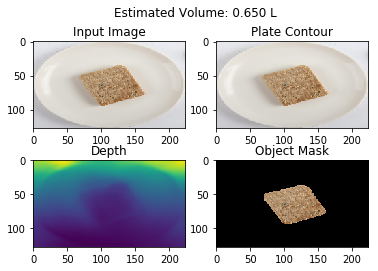

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.2950326622534062, -0.006144692303319257, -0.34851623487703126, -0.9372826024116928]
[*] Estimated volume: 0.6508301475909637 L


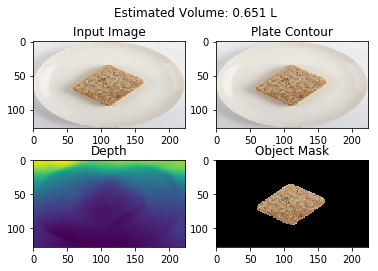

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.2954637587312176, -0.02436855800282279, -0.3122411667577656, -0.9496902795978341]
[*] Estimated volume: 0.563542896365474 L


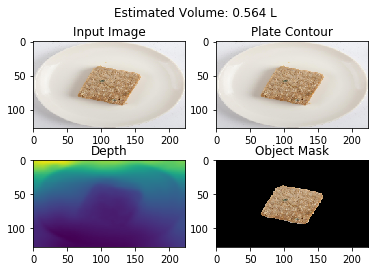

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.3114566527587797, -0.04409927954682185, -0.301557993902481, -0.952427440730769]
[*] Estimated volume: 0.7257226017693819 L


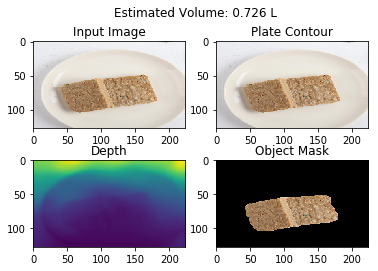

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.31689134238415034, 0.126624108297728, -0.2838410015138681, -0.9504738928857592]
[*] Estimated volume: 1.195935301868616 L


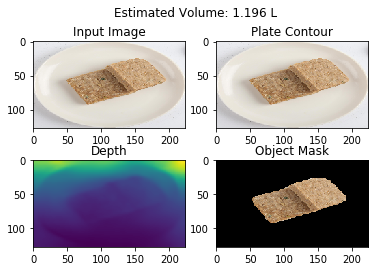

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.32249743480559345, -0.07516608509586241, -0.2884241922367321, -0.9545478222613837]
[*] Estimated volume: 0.5848811507757186 L


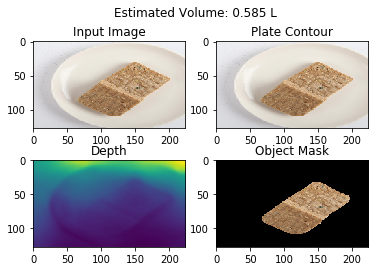

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.31135666389229805, -0.059688482095827985, -0.26929315437337564, -0.9612067842627482]
[*] Estimated volume: 1.1118344200996857 L


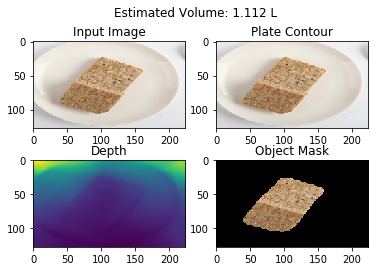

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.3168561114718857, -0.06513412097163258, -0.2631745831489101, -0.9625469781104973]
[*] Estimated volume: 1.0669709535816931 L


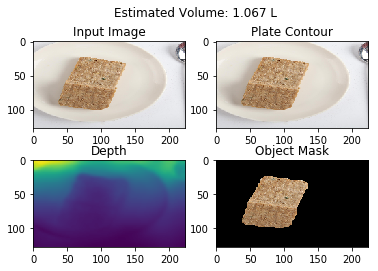

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.2932310567943362, 0.06938683629301083, -0.27054790762851827, -0.9602027372524397]
[*] Estimated volume: 0.7678771225961155 L


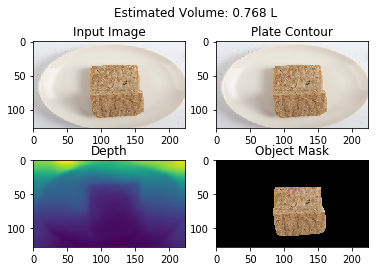

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.29691262928495893, 0.14111565476251692, -0.2820005219316926, -0.9489794927242627]
[*] Estimated volume: 0.9637327363562066 L


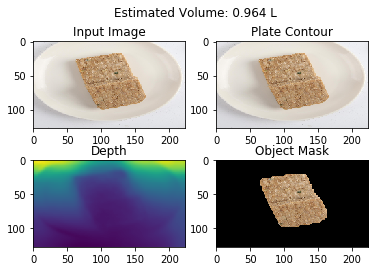

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.28968716130478095, 0.1350527915887751, -0.3063869200642837, -0.9422779837699707]
[*] Estimated volume: 1.2140466864827837 L


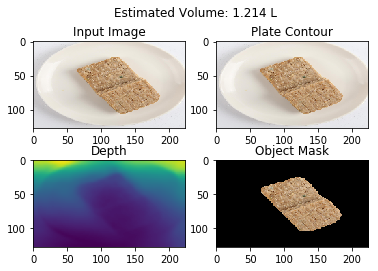

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.30943644142596743, 0.01491562759785569, -0.2841000302973857, -0.9586786202051167]
[*] Estimated volume: 1.3363768131205436 L


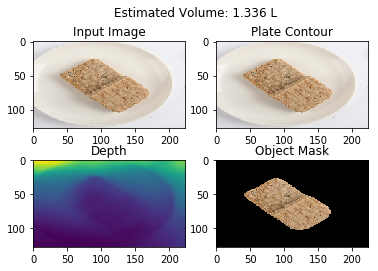

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 2 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.3100142784293206, 0.13701065595141562, -0.3198835562842496, -0.9374980483044772]
[*] Estimated volume: 0.24221267933465504 L


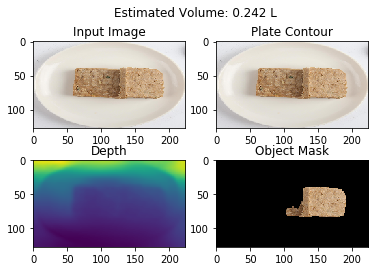

[*] Estimated plane parameters (w0,w1,w2,w3): [0.32068180234509813, 0.025731905431023043, -0.26881222609934635, -0.9628488230986226]
[*] Estimated volume: 0.3736251787845335 L


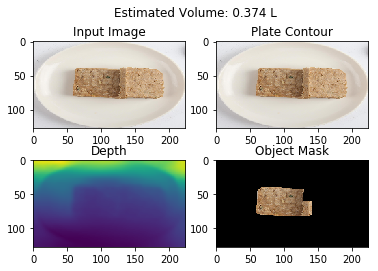

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 2 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.3340289343172707, 0.11104806561080242, -0.2509612902348295, -0.9616063424956017]
[*] Estimated volume: 1.288136031898458 L


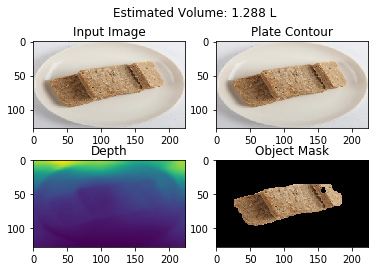

[*] Estimated plane parameters (w0,w1,w2,w3): [0.3383020909465053, 0.12268523084719289, -0.2872397527260213, -0.9499692934963031]
[*] Estimated volume: 0.10573774261994946 L


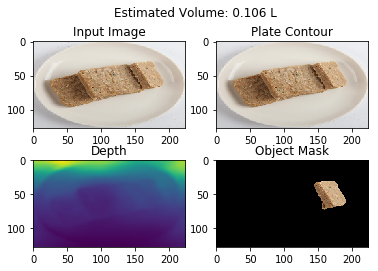

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.3069192649665967, 0.015257521013452811, -0.2739147476169785, -0.9616329440542535]
[*] Estimated volume: 1.3680915277778327 L


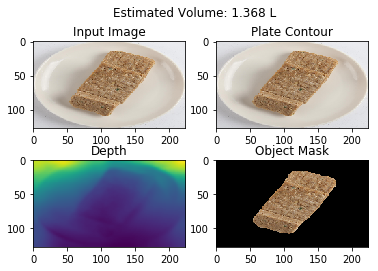

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 2 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.3039724873450145, 0.10219763218585975, -0.3298452176740925, -0.9384869612057135]
[*] Estimated volume: 1.0461715529286166 L


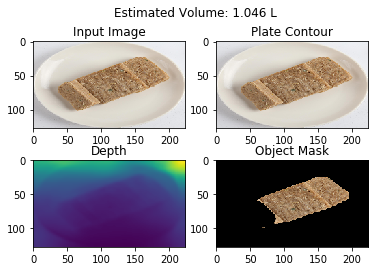

[*] Estimated plane parameters (w0,w1,w2,w3): [0.2719610200215387, -0.33375510101929173, -0.14981837049109237, -0.9306782410731412]
[*] Estimated volume: 0.09272077330378217 L


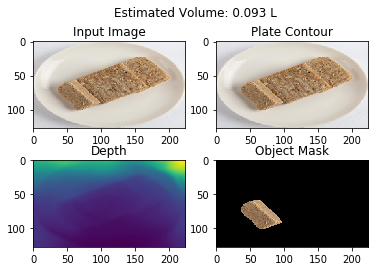

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 2 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.3150557612422335, -0.02391303028287431, -0.3274687763788481, -0.9445593509566408]
[*] Estimated volume: 1.678059678289701 L


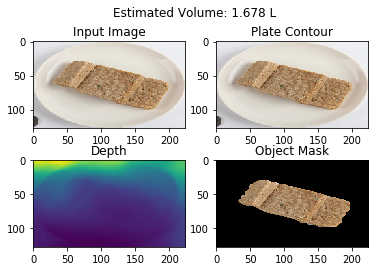

[*] Estimated plane parameters (w0,w1,w2,w3): [0.27982338991084343, -0.3509378217542357, -0.2604734960075265, -0.8994421621983314]
[*] Estimated volume: 0.40965161650164883 L


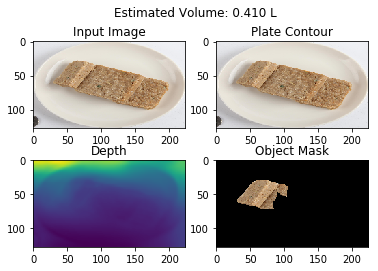

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 2 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.30528710782243046, 0.12648431767616086, -0.2424076080630479, -0.9618941048447838]
[*] Estimated volume: 0.9872684155442907 L


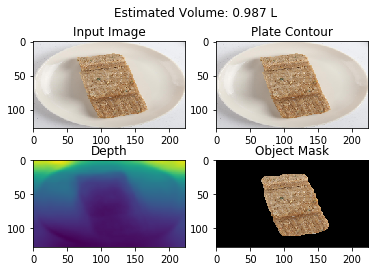

[*] Estimated plane parameters (w0,w1,w2,w3): [0.23135733118347052, -0.022199544111213755, -0.5429171336000149, -0.8394928029976183]
[*] Estimated volume: 0.27519941711158563 L


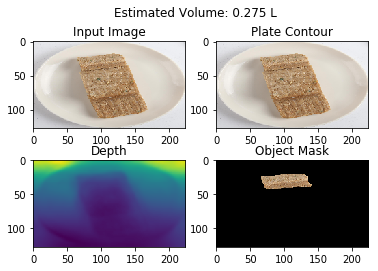

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 2 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.30003385381352277, -0.03371979698536494, -0.24990367375344974, -0.9676833826907411]
[*] Estimated volume: 0.8761846056540467 L


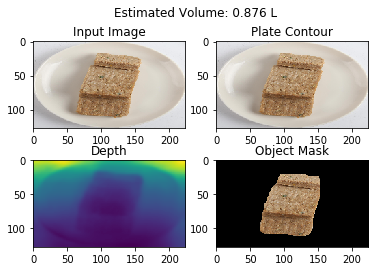

[*] Estimated plane parameters (w0,w1,w2,w3): [0.23429345553720568, 0.07859429508645575, -0.5205884173445795, -0.8501827077202458]
[*] Estimated volume: 0.19142581615539883 L


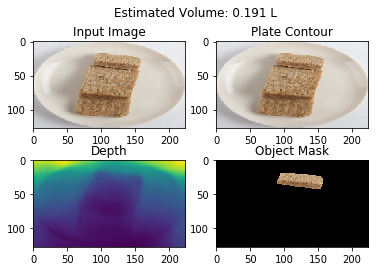

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 2 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.3242639953098958, 0.11150487119405911, -0.2812730254867393, -0.9531275616797219]
[*] Estimated volume: 0.7566129496399905 L


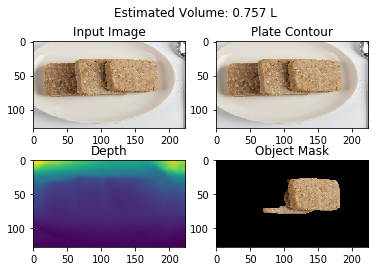

[*] Estimated plane parameters (w0,w1,w2,w3): [0.3265463737639622, -0.03748256067391748, -0.30538788516368764, -0.9514900405367239]
[*] Estimated volume: 0.2363828737840391 L


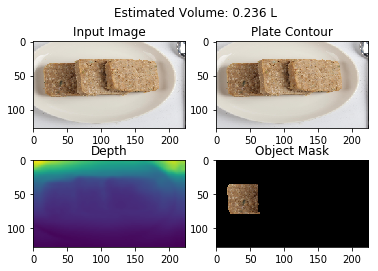

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 2 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.3271259343300085, 0.00016996060457760438, -0.26309971869282195, -0.964768629847152]
[*] Estimated volume: 1.4573811194454935 L


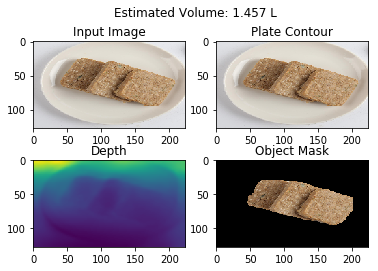

[*] Estimated plane parameters (w0,w1,w2,w3): [0.3036435785140277, -0.28309743603646526, -0.2177606580358082, -0.9340428991868581]
[*] Estimated volume: 0.37668846135853234 L


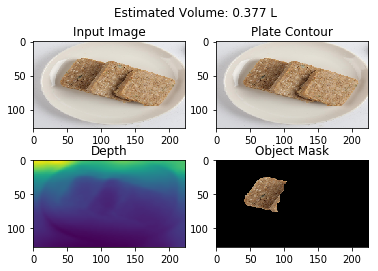

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.306409571048289, 0.07963770665225894, -0.3195812060545156, -0.9442063802029248]
[*] Estimated volume: 1.6764344360397465 L


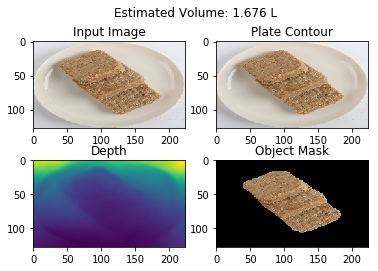

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.3062617462775195, 0.1300192773498904, -0.28403442865453715, -0.9499575942410813]
[*] Estimated volume: 1.5102755379621993 L


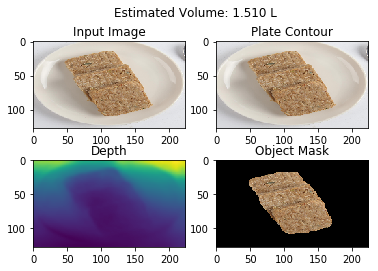

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.30792861963927143, -0.00566346230365967, -0.2691846028979742, -0.9630719468229749]
[*] Estimated volume: 1.3663135879060055 L


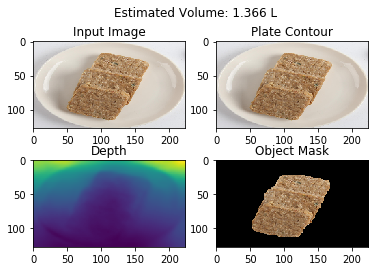

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 2 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.30528736198626005, -0.1396411933917375, -0.26000776193713593, -0.9554560695503341]
[*] Estimated volume: 0.4091103967439924 L


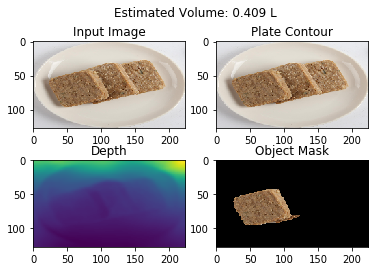

[*] Estimated plane parameters (w0,w1,w2,w3): [0.3078616039017518, 0.2471189426095617, -0.2772338968541961, -0.9284791837400389]
[*] Estimated volume: 0.6330478035276487 L


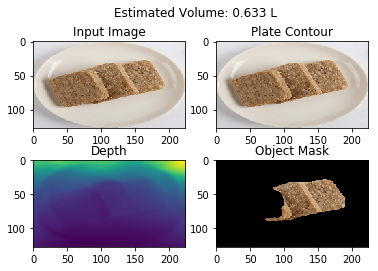

[*] Creating intrinsics matrix from given FOV: 70


/content/food_volume_estimation/food_volume_estimation/ellipse_detection/ellipse_center_estimator.py:84: RuntimeWarning: divide by zero encountered in double_scalars
  cab_x = (mb[1] - tb * mb[0] - ma[1] + ta * ma[0]) / (ta - tb)
/content/food_volume_estimation/food_volume_estimation/ellipse_detection/ellipse_center_estimator.py:85: RuntimeWarning: divide by zero encountered in double_scalars
  cab_y = (ta * mb[1] - tb * ma[1] + ta * tb * (ma[0] - mb[0])) / (ta - tb)


[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.3279803149402082, 0.013387125726662405, -0.2962086731724928, -0.9550294271917331]
[*] Estimated volume: 1.3004520421372703 L


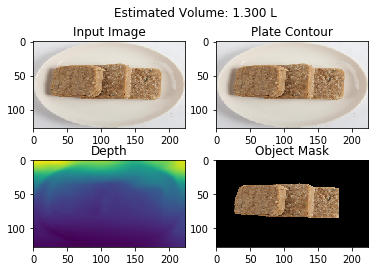

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.3261340719593198, 0.02374237819334287, -0.2894723120970501, -0.9568918852236715]
[*] Estimated volume: 1.7913426141692488 L


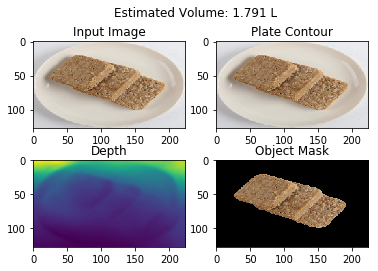

"\n  for outputs in outputs_list:\n      (estimated_volume, object_points_df, non_object_points_df, plane_points_df, object_points_transformed_df, \n          plane_points_transformed_df, simplices) = outputs\n      fig = plt.gcf()\n      fig.set_size_inches(6.5, 5.3)\n \n    # Flip x and z coordinates to match point cloud with plotting axes\n      object_points_df.values[:,0] *= -1\n      object_points_df.values[:,2] *= -1\n      non_object_points_df.values[:,0] *= -1\n      non_object_points_df.values[:,2] *= -1\n      plane_points_df.values[:,0] *= -1\n      plane_points_df.values[:,2] *= -1\n    \n    # Create point cloud objects and plot\n      object_pc = PyntCloud(object_points_df)\n      non_object_pc = PyntCloud(non_object_points_df)\n      plane_pc = PyntCloud(plane_points_df)\n      scene = object_pc.plot(initial_point_size=0.005, return_scene=True)\n      non_object_pc.plot(initial_point_size=0.005, scene=scene)\n      plane_pc.plot(initial_point_size=0.001, use_as_color='z

In [ ]:
result = []

for i in range(len(classes)):
  input_image = data_dir + classes[i]

  plate_diameter = 0.35 # Set as 0 to ignore plate detection and scaling
  outputs_list = estimator.estimate_volume(input_image, fov=70, plate_diameter_prior=plate_diameter, 
                                         plot_results=True)
  
  result.append([classes[i], volume[i]])
